Import a couple of libraries we are going to use:

In [1]:
import rasterio
import bokeh
import urllib.request
import zipfile
import os

Download and a multi-layer GeoTIFF, but **only** if it hasn't been downloaded and unzipped before:

In [2]:
if os.path.isfile('Africa.tif'):
    print("Africa.tif already downloaded and unzipped.")
else:
    urllib.request.urlretrieve("https://carsten.io/Africa.zip", "Africa.zip")
    zf = zipfile.ZipFile("Africa.zip")
    zf.extractall()
    zf.close()
    os.remove("Africa.zip") # clean up
    print("Download and unzip complete.")

Africa.tif already downloaded and unzipped.


Let's open the file with rasterio:

In [4]:
africa_tif = rasterio.open('Africa.tif')

Print some information about the dataset:

In [5]:
print("The file is called", africa_tif.name)
print()
print("It is", africa_tif.width, "x",africa_tif.height,"pixels big")
print()
print("It covers the following extent:",africa_tif.bounds)
print()
print("It is in the following CRS:",africa_tif.crs)

The file is called Africa.tif

It is 10663 x 10117 pixels big

It covers the following extent: BoundingBox(left=-25.360422329999892, bottom=-46.96575286299996, right=63.493907097000005, top=37.34520091400016)

It is in the following CRS: EPSG:4326


How many layers are there in this GeoTIFF, and what data types do they use?

In [6]:
{i: dtype for i, dtype in zip(africa_tif.indexes, africa_tif.dtypes)}

{1: 'int16', 2: 'int16', 3: 'int16', 4: 'int16'}

Let's take a look at the layers:

In [7]:
import matplotlib as mlp
from rasterio.plot import show
import matplotlib.pyplot as plt
%matplotlib inline 

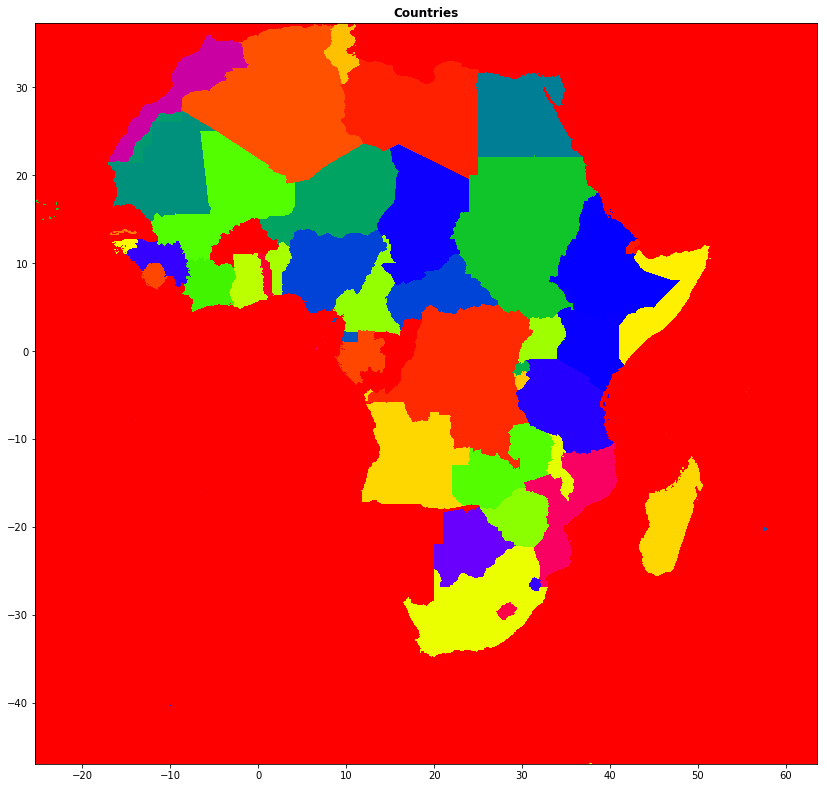

In [8]:
plt.figure(figsize=(14, 14))
show((africa_tif, 1), title='Countries', cmap='prism')

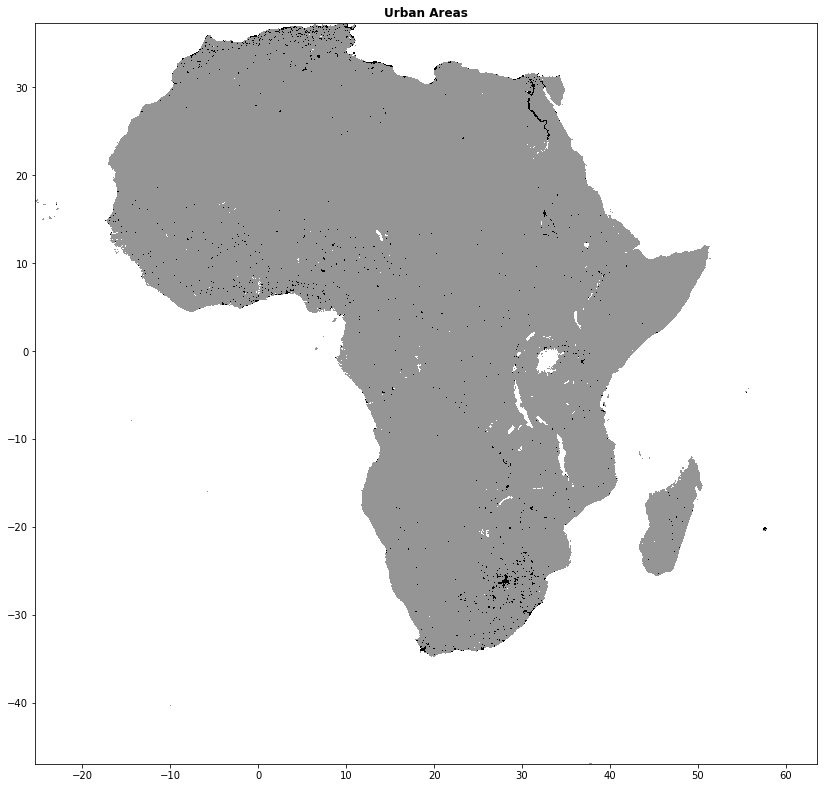

In [9]:
plt.figure(figsize=(14, 14))
show((africa_tif, 3), title='Urban Areas', cmap='Greys')

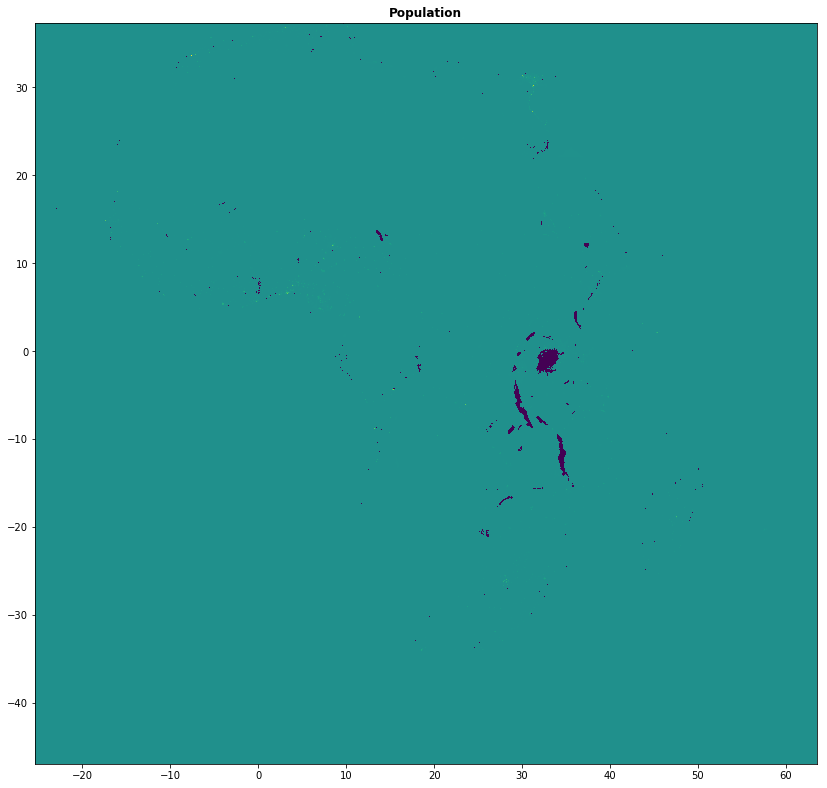

In [10]:
plt.figure(figsize=(14, 14))
show((africa_tif, 2), title='Population')

Not great, let's try to improve this:

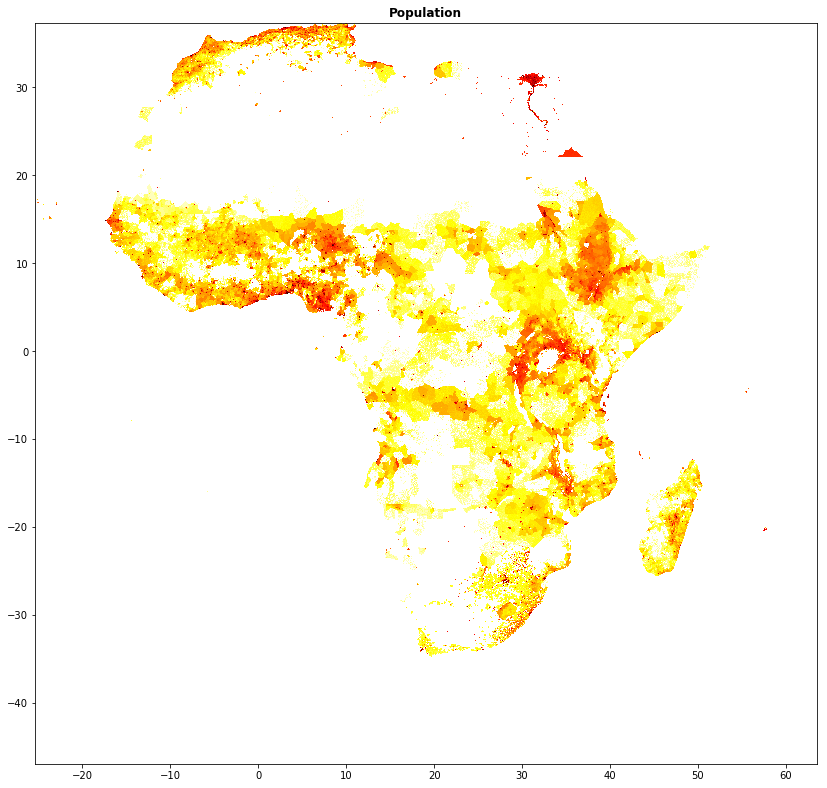

In [11]:
from matplotlib.colors import LogNorm

plt.figure(figsize=(14, 14))
show((africa_tif, 2), title='Population', norm=LogNorm(), cmap='hot_r')

Can we add a legend?

In [43]:
pop = africa_tif.read(2)

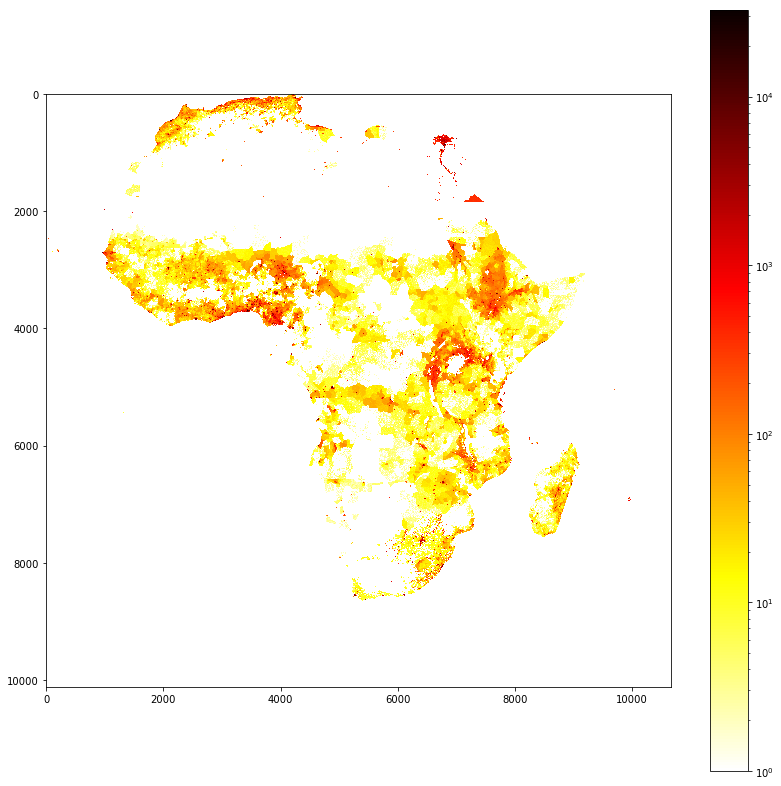

In [13]:
plt.figure(figsize=(14, 14))

imgplot = plt.imshow(pop, norm=LogNorm(), cmap='hot_r')
plt.colorbar()

Alternative: Interactive plots with Bokeh:

In [14]:
import numpy as np
import bokeh.plotting as bkplt

In [15]:
pop.shape

(10117, 10663)

In [16]:
p = bkplt.figure(x_range=(0, pop.shape[0]), y_range=(0, pop.shape[1]))

# must give a vector of image data for image parameter
p.image(image=[pop], x=0, y=0, dw=pop.shape[0], dh=pop.shape[1], palette="Spectral11")

bkplt.show(p)

Bokeh can also make web maps:

In [17]:
from bokeh.tile_providers import CARTODBPOSITRON

# range bounds supplied in web mercator coordinates
p = bkplt.figure(x_range=(-2000000, 6000000), y_range=(-1000000, 7000000),
           x_axis_type="mercator", y_axis_type="mercator")
p.add_tile(CARTODBPOSITRON)

bkplt.show(p)

# Compression

In [18]:
def compress(inputfile, outputfile, layer, compression, datatype):
    
    with rasterio.Env():

        # Write an array as a raster band to a new 8-bit file. For
        # the new file's profile, we start with the profile of the source
        profile = inputfile.profile

        # And then change the band count to 1, set the
        # dtype to uint8, and specify LZW compression.
        profile.update(
            dtype=datatype,
            count=1,
            compress=compression)

        with rasterio.open(outputfile, 'w', **profile) as dst:
            dst.write(layer.astype(datatype), 1)

In [19]:
compress(africa_tif, 'pop-float.tif',     pop, None, rasterio.float32)
compress(africa_tif, 'pop-float-lzw.tif', pop, 'lzw', rasterio.float32)
compress(africa_tif, 'pop-int-lzw.tif',   pop, 'lzw', rasterio.int32)

Let's do the urban layer to test int8:

In [20]:
urban = africa_tif.read(3)
compress(africa_tif, 'urban-int-lzw.tif', urban, 'lzw', rasterio.int8)

# Map Algebra

In [21]:
import seaborn as sns     
from scipy import signal  # for the focal function
from skimage import graph # can do least cost

Let's define two layers, let's say one is ground elevation, the other one is the height of vegeation above ground:


In [22]:
elevation = np.array([ [ 1, 1, 3, 4, 4, 2],
                       [ 1, 3, 4, 4, 2, 1],
                       [ 1, 2, 2, 3, 2, 0],
                       [ 1, 1, 2, 4, 0, 0]])

building = np.array([ [0, 1, 1, 1, 1, 2],
                       [ 1, 1, 1, 1, 1, 1],
                       [ 0, 1, 2, 3, 4, 0],
                       [ 0, 1, 0, 1, 0, 0]])

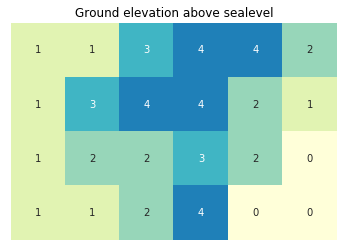

In [23]:
fig = sns.heatmap(elevation, 
                  annot=True, square=True, xticklabels=False, yticklabels=False, 
                  cmap="YlGnBu", cbar=False, vmin=0, vmax=6).set_title('Ground elevation above sealevel')

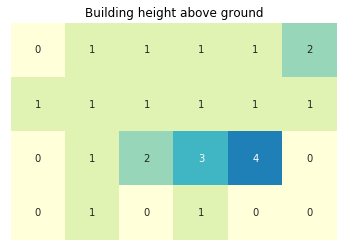

In [24]:
fig = sns.heatmap(building, 
                  annot=True, square=True, xticklabels=False, yticklabels=False, 
                  cbar=False, cmap="YlGnBu", vmin=0, vmax=6).set_title('Building height above ground')

### 1. Local operation: Calculate building height above sea level

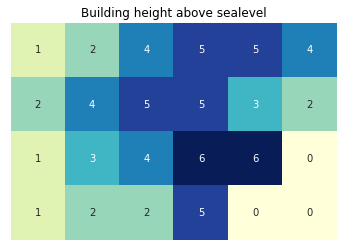

In [25]:
building_above_sealevel = elevation + building

fig = sns.heatmap(building_above_sealevel, 
                  annot=True, square=True, xticklabels=False, yticklabels=False, 
                  cbar=False, cmap="YlGnBu").set_title('Building height above sealevel')

### 2. Focal operation: Fix errors in elevation raster

Let's assume our elevation raster has a measurement error, e.g. because a bird flew under the LiDAR, so one pixel has  a too high value:

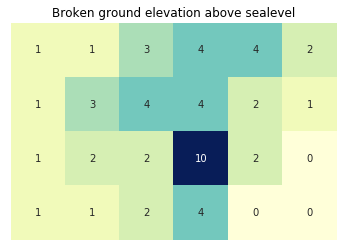

In [26]:
broken_elevation = elevation
broken_elevation[2,3] = 10

fig = sns.heatmap(broken_elevation, annot=True, square=True, xticklabels=False, yticklabels=False, 
                  cbar=False, cmap="YlGnBu").set_title('Broken ground elevation above sealevel')

We'll fix this by running a 3x3 window over it that sets every pixel to the average of it's 8 neighbors:

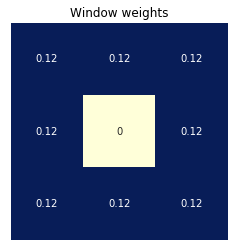

In [27]:
window = np.array([ [ 1/8., 1/8., 1/8.,],
                    [ 1/8., 0, 1/8.,],
                    [ 1/8., 1/8., 1/8.,],])

fig = sns.heatmap(window, annot=True, square=True, xticklabels=False, yticklabels=False, 
                  cbar=False, cmap="YlGnBu").set_title('Window weights')

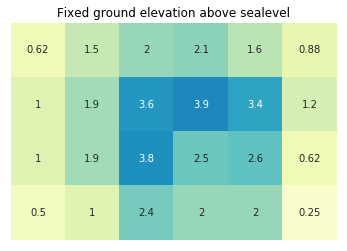

In [28]:
fixed_elevation = signal.convolve(broken_elevation, window, mode="same") # "moving window" function

fig = sns.heatmap(fixed_elevation, annot=True, square=True, xticklabels=False, yticklabels=False, 
                  cbar=False, cmap="YlGnBu", vmin=0, vmax=6).set_title('Fixed ground elevation above sealevel')

Note that functions like this one always affect **all cells** (not just the "broken" one) and have **edge effects**!

## 3. Zonal operation: Average vegetation height per zone

Let's define two zones and calculate the average vegetation height per zone:

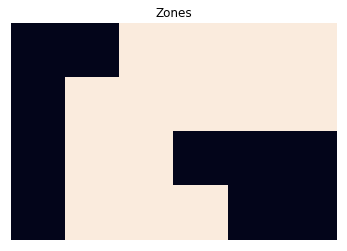

In [29]:
zones = np.array([ [0, 0, 1, 1, 1, 1],
                   [0, 1, 1, 1, 1, 1],
                   [0, 1, 1, 0, 0, 0],
                   [0, 1, 1, 1, 0, 0]])

fig = sns.heatmap(zones, square=True, xticklabels=False, yticklabels=False, cbar=False).set_title('Zones')

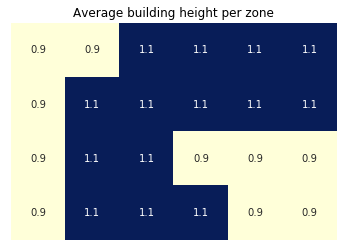

In [30]:
avg_veg_height = np.copy(zones).astype(float)

for zone in np.unique(zones):
    avg_veg_height[zones == zone] = np.mean(building[zones == zone])
    
fig = sns.heatmap(avg_veg_height, annot=True, cmap="YlGnBu", square=True, xticklabels=False, yticklabels=False, 
                  cbar=False).set_title('Average building height per zone')

## 4. Global operation: Cost distance

We'll use or elevation layer as a cost surface and calculate the cost to travel to each cell from a given start cell.

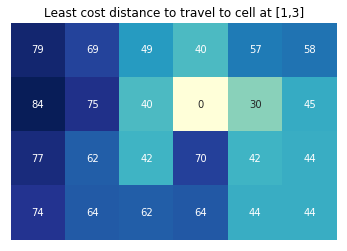

In [31]:
# turn our elevation into a cost surface
cellSize = 10
lg = graph.MCP_Geometric(elevation, sampling=(cellSize, cellSize))

# Calculate the least-cost distance from the start cell to all other cells
lcd = lg.find_costs(starts=[(1, 3)])[0]
fig = sns.heatmap(lcd, annot=True, square=True, xticklabels=False, yticklabels=False, 
                  cbar=False, cmap="YlGnBu").set_title('Least cost distance to travel to cell at [1,3]')

Calculate an example path, here from the top left pixel to our source, using [route_through_array](http://scikit-image.org/docs/0.7.0/api/skimage.graph.mcp.html#route-through-array)

In [32]:
from skimage.graph import route_through_array

In [33]:
route_through_array(elevation, [0, 1], [1, 3])

([(0, 1), (0, 2), (1, 3)], 6.949747468305833)

# Numpy

In [34]:
pop

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)

In [35]:
pop.size

107877571

In [36]:
pop.shape

(10117, 10663)

In [37]:
pop[pop > 1000]

array([1258, 1284, 1265, ..., 3198, 2527, 1315], dtype=int16)

In [38]:
countries = africa_tif.read(1)

In [39]:
egypt = countries == 818 # = Egypt
egypt

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

Combining layers!

In [40]:
np.sum(pop[egypt]) # what is happening here?

-108620901

Wait, what? Let's fix that:

In [45]:
pop[pop < 0] = 0

In [46]:
popegypt = np.sum(pop[egypt]) 
"{:,}".format(popegypt)

'81,662,875'

Identify the urban and rural cells in Egypt:

In [47]:
cities = urban == 2
rural  = urban == 1

Now we can count them to calculate the number of urban and rural cells in Egypt (or any other country) in 2010:

In [48]:
urbanEgypt = np.all((egypt, cities), axis=0)
ruralEgypt = np.all((egypt, rural), axis=0)

When applied to boolean arrays, [np.sum](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.sum.html) treats ```True``` like 1 and ```False``` like 0:

In [49]:
print("Urban cells in Egypt:","{:,}".format(np.sum(urbanEgypt)))
print("Rural cells in Egypt:","{:,}".format(np.sum(ruralEgypt)))

Urban cells in Egypt: 33,689
Rural cells in Egypt: 1,267,349


## Can we calculate the urban area from this?

Let's take a look [here](https://bl.ocks.org/atanumallick/8d18989cd538c72ae1ead1c3b18d7b54) and [here](https://bl.ocks.org/syntagmatic/ba569633d51ebec6ec6e)

# 🏋 Exercises

👉 **Calculate the *total* population and *urban* population for each country in Africa**

In [52]:
for c in np.unique(countries):
    print(c, "{:,}".format(np.sum(pop[countries == c])))

0 0
12 38,615,393
24 22,163,601
72 2,422,366
108 8,381,284
120 22,517,640
132 499,673
140 4,532,869
148 11,650,688
174 681,595
178 4,122,015
180 67,391,405
204 9,045,816
226 1,147,244
231 83,073,461
232 5,206,923
262 939,246
266 1,961,972
270 1,698,270
288 25,099,168
324 9,897,569
384 20,213,177
404 39,897,613
426 2,171,319
430 4,002,375
434 8,080,787
450 20,879,693
454 14,899,366
466 15,686,436
478 3,528,187
480 1,335,268
504 31,771,574
508 23,999,372
516 2,502,288
562 15,950,291
566 163,442,380
624 1,466,796
646 10,621,758
654 4,317
678 164,894
686 12,453,332
690 80,028
694 5,586,005
706 9,348,055
710 52,289,904
716 12,611,957
728 12,411,988
729 35,905,925
732 195,842
748 1,185,981
768 6,047,276
788 10,796,613
800 33,424,033
818 81,662,875
834 44,736,304
854 16,480,063
894 13,180,063


👉 **Generate a raster that indicates the distance to the closest urban cell for every cell in the output raster and visualize that raster**

First, pick out all the urban cells, which will be our source cells for the cost surface:

In [56]:
u = np.where(urban == 2)
u

(array([   1,    1,    1, ..., 8633, 8633, 8633]),
 array([4220, 4221, 4222, ..., 5364, 5365, 5371]))

Zip the two arrays to get the x and y positions of our urban source cells as a pair of indeces that we can pass on the the lest cost surface calculation:

In [58]:
urbanIndexes = [(x,y) for x,y in zip(u[0], u[1])]
urbanIndexes

[(1, 4220),
 (1, 4221),
 (1, 4222),
 (1, 4223),
 (2, 4219),
 (2, 4220),
 (2, 4221),
 (2, 4222),
 (2, 4223),
 (2, 4224),
 (2, 4225),
 (3, 4219),
 (3, 4220),
 (3, 4221),
 (3, 4222),
 (3, 4223),
 (3, 4224),
 (3, 4225),
 (4, 4218),
 (4, 4219),
 (4, 4220),
 (4, 4221),
 (4, 4222),
 (4, 4223),
 (4, 4224),
 (4, 4225),
 (5, 4217),
 (5, 4218),
 (5, 4219),
 (5, 4220),
 (5, 4221),
 (5, 4222),
 (5, 4223),
 (5, 4224),
 (5, 4225),
 (6, 4217),
 (6, 4218),
 (6, 4219),
 (6, 4220),
 (6, 4221),
 (6, 4222),
 (6, 4223),
 (6, 4224),
 (6, 4225),
 (7, 4216),
 (7, 4217),
 (7, 4218),
 (7, 4219),
 (7, 4220),
 (7, 4221),
 (7, 4222),
 (7, 4223),
 (7, 4224),
 (7, 4225),
 (8, 4217),
 (8, 4218),
 (8, 4219),
 (8, 4220),
 (8, 4221),
 (8, 4222),
 (8, 4223),
 (8, 4224),
 (8, 4225),
 (9, 4215),
 (9, 4216),
 (9, 4217),
 (9, 4218),
 (9, 4219),
 (9, 4220),
 (9, 4221),
 (9, 4222),
 (9, 4223),
 (9, 4224),
 (9, 4228),
 (9, 4229),
 (9, 4248),
 (9, 4249),
 (10, 4216),
 (10, 4217),
 (10, 4218),
 (10, 4219),
 (10, 4220),
 (10, 4221)

Make a "fake" cost surface where the cost for each cell is 1:

In [59]:
fake_cost = np.ones_like(pop)
fake_cost

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int16)

Calculate the cost surface:

In [61]:
lg = graph.MCP_Geometric(fake_cost)

# Calculate the least-cost distance from the start cell to all other cells
lcd = lg.find_costs(starts=urbanIndexes)[0]

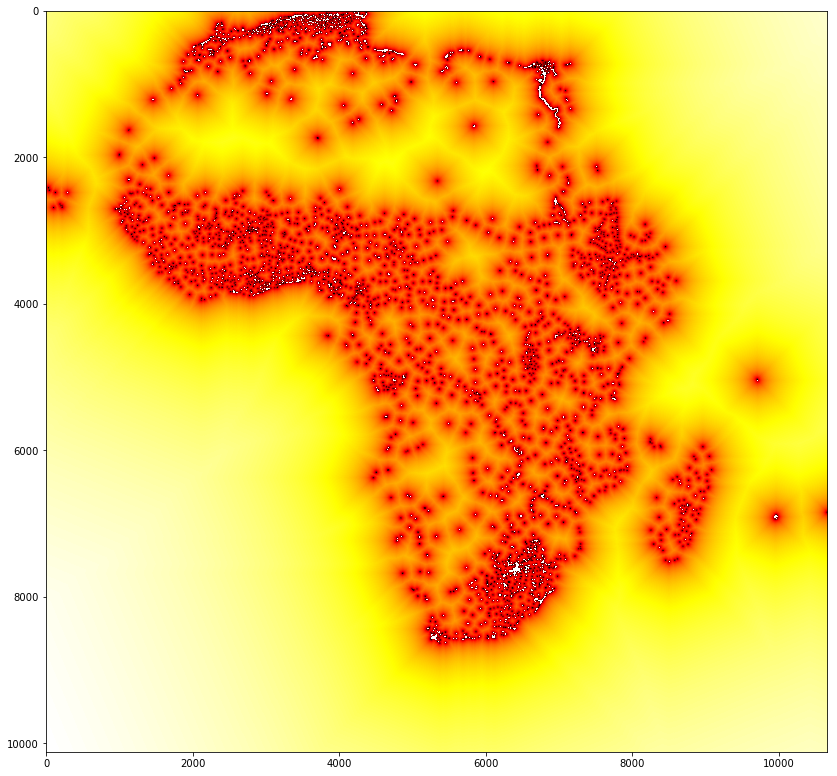

In [65]:
plt.figure(figsize=(14, 14))
imgplot = plt.imshow(lcd, norm=LogNorm(), cmap='hot')

👉 **Download [zoo.tif](https://www.dropbox.com/s/1w97ohqkcjgu2ku/zoo.tif?dl=0) and calculate [slope and aspect](https://stackoverflow.com/questions/47653271/calculating-aspect-slope-in-python3-x-matlab-gradientm-function) and generate a [hillshade visualization](https://matplotlib.org/gallery/specialty_plots/topographic_hillshading.html)**

In [69]:
from osgeo import gdal

Take a look at the DEM:

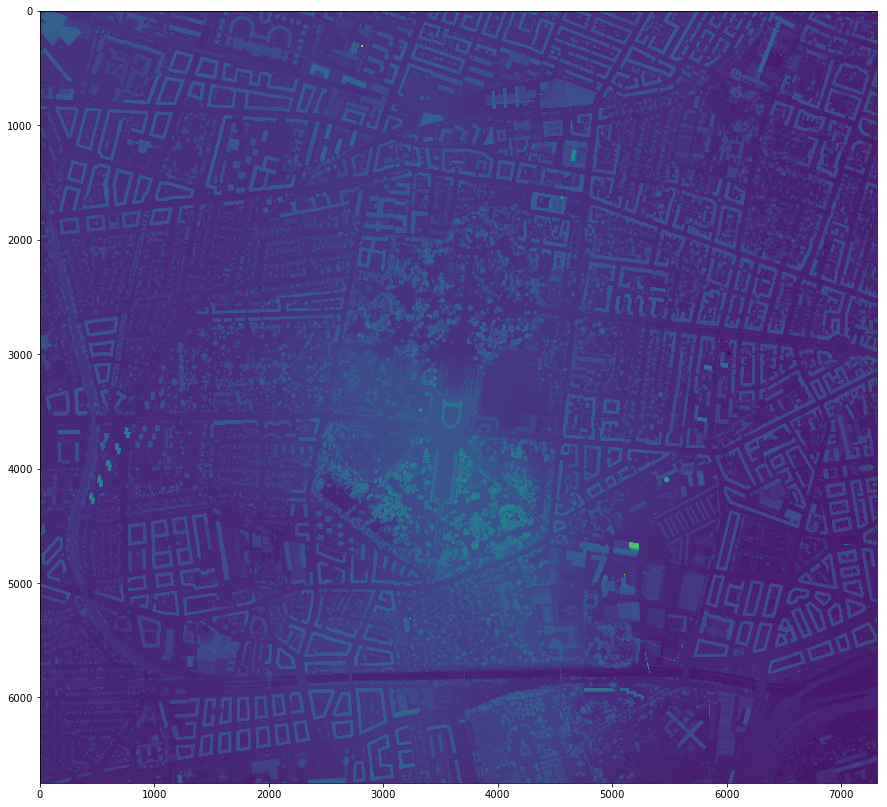

In [78]:
with rasterio.open('zoo.tif') as dataset:
    dem=dataset.read(1)
    plt.figure(figsize=(15, 15))
    imgplot = plt.imshow(dem)

The python binding for the [DEMprocessing](https://gdal.org/python/osgeo.gdal-module.html#DEMProcessing) function in GDAL seems to be buggy, so we'll do that directly on the CLI:

In [95]:
!gdaldem slope zoo.tif zoo_slope.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


In [96]:
!gdaldem aspect zoo.tif zoo_aspect.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


In [97]:
!gdaldem hillshade zoo.tif zoo_hillshade.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


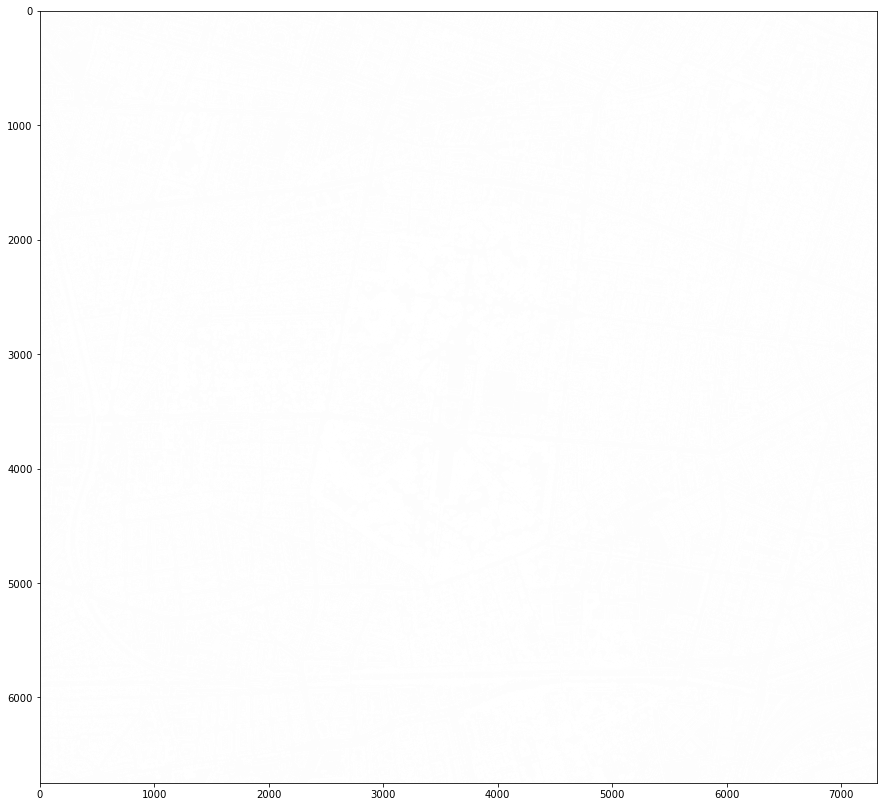

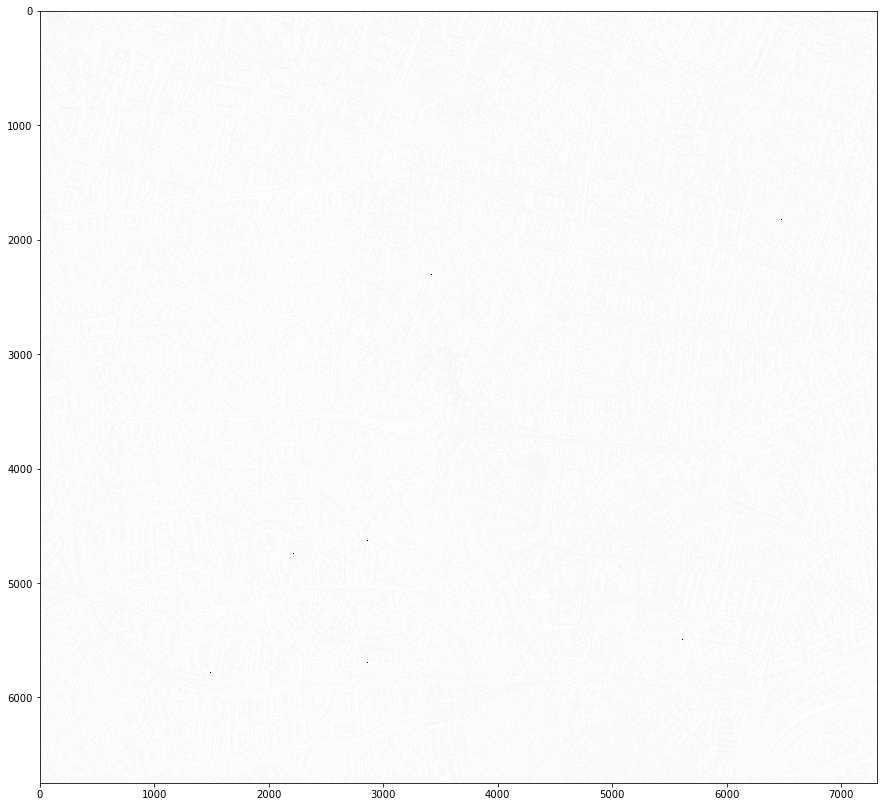

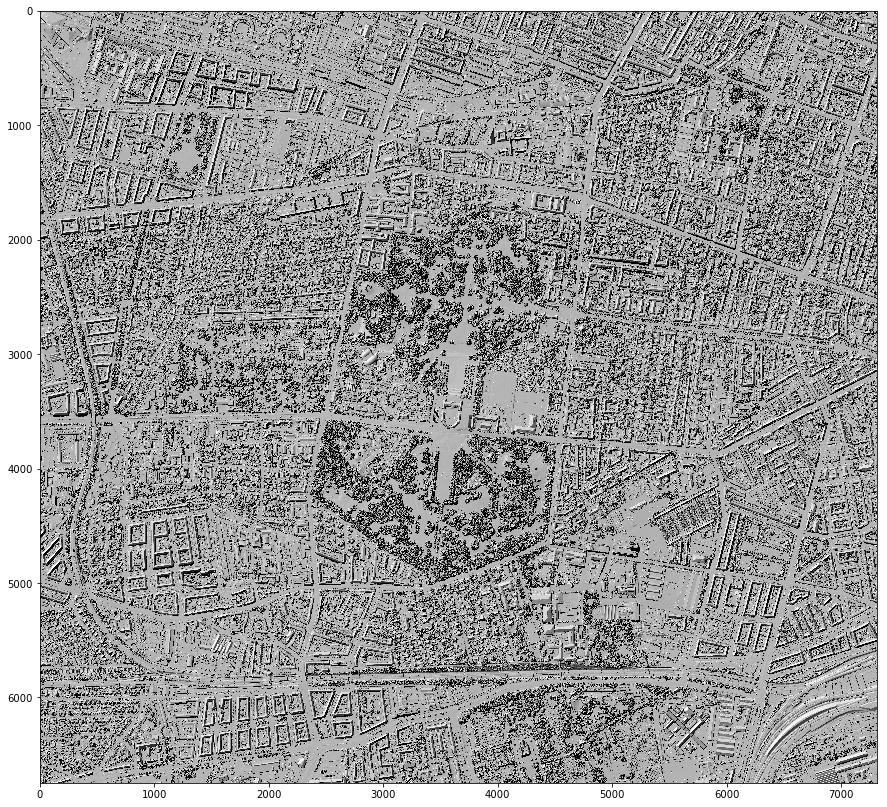

In [101]:
for ds in ['zoo_slope.tif', 'zoo_aspect.tif', 'zoo_hillshade.tif']:
    with rasterio.open(ds) as dataset:
        dem=dataset.read(1)
        plt.figure(figsize=(15, 15))
        imgplot = plt.imshow(dem, cmap='gray')